# Image duplicate detection via OpenCV's Hashing module & Hamming distance

# Author: Ricardo Aceved-Avila (https://github.com/gone-still)

# Date: 27/10/2023

In [ ]:
# Install opencv:
!pip install opencv-python

In [1]:
# Imports:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Mount the drive and set the image paths:

In [2]:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

# Get images:
imagePath1 = "/content/drive/MyDrive/imgs/alf01.png"
imagePath2 = "/content/drive/MyDrive/imgs/cat01.png"

Mounted at /content/drive


This function receives the hasg string as a numpy array of 32 bits and converts it to a hexadecimal string, using two nibbles per integer:

In [3]:
# Define the hash 32-bit decoder function:
def getHashString(inputArray):
    # Store the hash string here:
    outString = ""
    for i in range(inputArray.shape[0]):
        # Get int from array, convert to hex and then to string:
        hexChar = str(hex(inputArray[i]))
        # Discard the "0x" prefix:
        hexChar = hexChar[2:]
        # Each int is encoded using two nibbles:
        if len(hexChar) == 1:
            # Fill the most significant nibble with "0"
            hexChar = "0" + hexChar

        # Concatenate:
        outString = outString + str(hexChar)[-2:]
    # Done:
    return outString

This function receives an image, as a numpy array, and adds gaussian noise with a mean *m* an a standard deviation *sigma* to each color channel:

In [4]:
# Add gaussian noise to an input image:
def gaussianNoise(inputImage, mean=0.0, var=0.01):
    # Convert image to float in the range [0.0, 1.0]:
    inputImage = inputImage / 255.0

    # Get image dimensions:
    (imgHeight, imgWidth) = inputImage.shape[0:2]

    # Compute sigma:
    sigma = np.sqrt(var)

    # Prepare out image:
    outImage = np.zeros(inputImage.shape, np.float32)

    # Add noise to the BGR image:
    outImage[:, :, 0] = inputImage[:, :, 0] + np.random.normal(loc=0, scale=sigma, size=(imgHeight, imgWidth))
    outImage[:, :, 1] = inputImage[:, :, 1] + np.random.normal(loc=0, scale=sigma, size=(imgHeight, imgWidth))
    outImage[:, :, 2] = inputImage[:, :, 2] + np.random.normal(loc=0, scale=sigma, size=(imgHeight, imgWidth))

    # Normalize and back to uint8:
    outImage = np.clip(outImage, 0.0, 1.0) * 255
    outImage = outImage.astype(np.uint8)

    # Return the image:
    return outImage

This function computes the Hamming distance between two strings. The Hamming distance yields the number of different symbols between the two strings. It is important that each symbol is encoded in the same position, using two nibbles per symbol:

In [5]:
# Define the hamming distance function:
# string1 and string2 should be the same length.
def hammingDistance(string1, string2):
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance


Let's create a list in which all the images will be stored. I'll add the first image two times, as the objective of the script is to delete image duplicates. Let's use colab's unofficial *cv2_imshow* function to display the images:

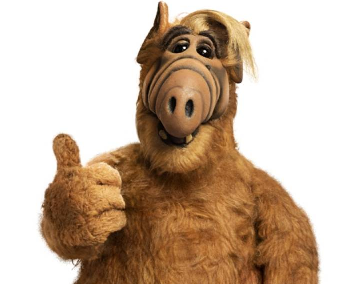

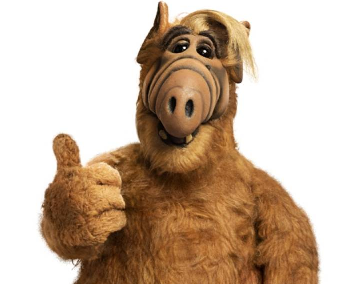

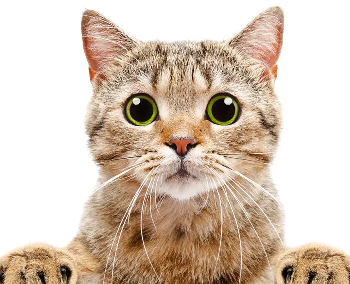

In [26]:
# The images are stored here:
imageList = []
# Check out the images:
for currentPath in [imagePath1, imagePath1, imagePath2]:
    # Read images:
    currentImage = cv2.imread(currentPath)
    # Store images:
    imageList.append(currentImage)
    cv2_imshow(currentImage)

Let's add in a copy of one original image corrupted by Gaussian noise.I'm using a mean of **0.0** and a variance of **0.01**:

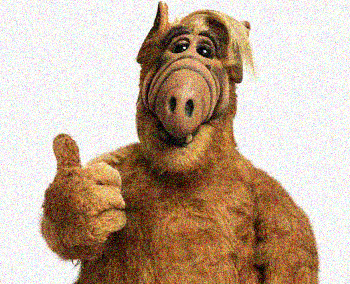

In [27]:
# Create noisy image:
noisyImage = gaussianNoise(imageList[0], 0, 0.01)

# Into the image list:
imageList.append(noisyImage)

cv2_imshow(noisyImage)

We have four images: Two ALF duplicates, one cat and one ALF corrupted with Gaussian noise. Let's set some script variables. We will rescale the image to a smaller size (**25%** of the original scale), and will use a dictionary to store the Hashed strings along their image. I'll instantiate an OpenCV Hashing object. Lastly, I'll use a simple list to keep track of the **unique Hash Strings (excluding duplicates)** generated:

In [34]:
# Set the "hashing scale":
imageScale = (0.25, 0.25)

# Prepare the dictionary of duplicated hashes:
hashTable = {}

# Prepare the image hashing object:
hasher = cv2.img_hash.BlockMeanHash_create()

# Store unique images/keys here:
keyList = []

Let's process the images. This bit loops through every image stored in the **imagesList** variable. Every image is converted to grayscale and resized. The Hash String is obtained with a call to the Hashing object, which returns a numpy array of 32-bit integers. We then convert this array into a string made out of hexadecimal digits. The string is used as key and the image stored as a value in the Hash dictionary. Similar* images will produce the same key. We will store the "*parent*" key and a list of duplicates for every entry.

An additional flag will be used to identify **unique images** (first entry) from its duplicates:

**By resizing the image first, the hashing will ignore small differences between similar images and produce the same keys.*

Image: 0 Hash: ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780


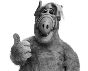

Image: 1 Hash: ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780


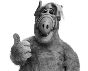

Image: 2 Hash: ffffefe74fe10fe00ff01ff80fe00fe00ff01ff41ff20ff00fe00fe000000000


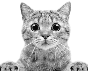

Image: 3 Hash: ffff7ff83ff83ff83ff83ff83ff83ff813f817f003e003c003c003c007800780


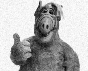

In [35]:
# Process the images:
for i, currentImage in enumerate(imageList):

    # BGR to Gray:
    grayImage = cv2.cvtColor(currentImage, cv2.COLOR_BGR2GRAY)

    # Scale down the image by the scale factor:
    grayImage = cv2.resize(grayImage, None, fx=imageScale[0], fy=imageScale[0])

    # Compute image hash:
    imageHash = hasher.compute(currentImage)

    # Convert 32-bit array into string:
    hashString = getHashString(imageHash[0])

    print("Image:", i, "Hash:", hashString)
    cv2_imshow(grayImage)

    # Into the hash table. Every entry is a list item:
    if hashString not in hashTable:
        # First entry, original flag is True:
        hashTable[hashString] = [[currentImage, True]]
        # Unique keys into the list:
        keyList.append(hashString)
    else:
        # Subsequent entries, original flag is False:
        hashTable[hashString].append([currentImage, False])


Let's check out the number of unique entries:

In [36]:
# Get number of unique images:
uniqueImages = len(keyList)
print("Unique images: ", uniqueImages)

Unique images:  3


**Image 0** and **Image 2** produce the same Hash String and are identified as the same image, meanwhile **Image 0** and **Image 3** have enough differences to produce different keys. **Only unique images are stored in the keyList.** Let's compute the Hamming distance between every unique Hash String in search for small variations. Let's the define a maximum threshold for this. This threshold is actually the difference in number of digits that we will alow for two strings to be considered the same image:

In [37]:
# Distance Threshold:
maxDistance = 10

# Process only unique keys in the unique images/keys list:
for i in range(uniqueImages):
    # Get source key:
    sourceKey = keyList[i]
    for j in range(i + 1, uniqueImages):
        # Get source key:
        targetKey = keyList[j]

        # Compute hamming distance:
        currentDistance = hammingDistance(sourceKey, targetKey)
        print(" Target:", i, "-> Source:", j, " Distance:", currentDistance)

        # Check distance:
        if currentDistance <= maxDistance:
            print("Target: ", targetKey, " seems to be duplicate of: ", sourceKey)

            # Get duplicated entry (list):
            targetEntry = hashTable[targetKey][0]
            # Change first entry flag:
            targetEntry[1] = False
            # Add to original entry:
            hashTable[sourceKey].append(targetEntry)
            # Remove duplicated:
            del hashTable[targetKey]
            print("Deleted Target: ", targetKey)

 Target: 0 -> Source: 1  Distance: 38
 Target: 0 -> Source: 2  Distance: 1
Target:  ffff7ff83ff83ff83ff83ff83ff83ff813f817f003e003c003c003c007800780  seems to be duplicate of:  ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780
Deleted Target:  ffff7ff83ff83ff83ff83ff83ff83ff813f817f003e003c003c003c007800780
 Target: 1 -> Source: 2  Distance: 37


**Image 0** and **Image 2** (previously, **Image 3**) are off by just **two** hexadecimal digits, thus, are also recognized as being the same image. The duplicate gets appendend to the list of duplicated for the first image while its unique key is deleted from the Hash dictionary.

Now, let's keep only the unique entries on the dictionary, we will use the "*unique flag*" to identify original entries and delete the rest:

In [38]:
# Check items on the hash table:
for key in hashTable:

    # Get dic entry:
    currentDuplicates = hashTable[key]
    # Get key duplicates:
    totalDuplicates = len(currentDuplicates)

    # Print how many duplicates are found for this particular image (key):
    print("Examining duplicates for: ", key, "Duplicates found: ", totalDuplicates)

    # Check out duplicates:
    for i in range(totalDuplicates - 1, 0, -1):

        print(" Duplicate: ", i)
        # Get the current duplicate:
        currentList = currentDuplicates[i]
        # Get duplicate flag:
        duplicateFlag = currentList[1]

        # Remove duplicate:
        if not duplicateFlag:
            hashTable[key].pop()
            print(" - Removed element: ", i)

Examining duplicates for:  ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780 Duplicates found:  3
 Duplicate:  2
 - Removed element:  2
 Duplicate:  1
 - Removed element:  1
Examining duplicates for:  ffffefe74fe10fe00ff01ff80fe00fe00ff01ff41ff20ff00fe00fe000000000 Duplicates found:  1


Aside from the corrupted image, there was an exact duplicate of *image 1*. This one gets removed from the dictionary. Let's show the final contents of the Hash dictionary. There should be only unique entries so far - One image of ALF and one image of our lovely cat:

Key:  ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780  images:  1


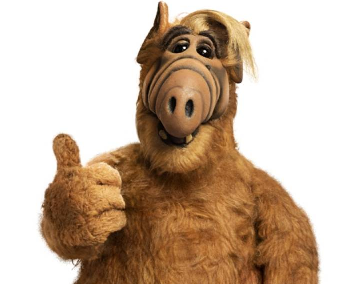

Key:  ffffefe74fe10fe00ff01ff80fe00fe00ff01ff41ff20ff00fe00fe000000000  images:  1


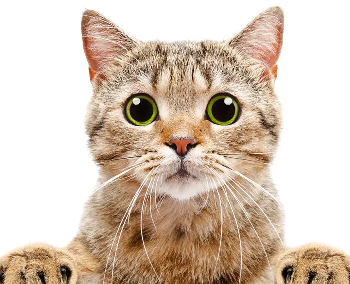

In [39]:
# Show original images:
for key in hashTable:

    # Get image count (should be 1 -> the original entry):
    imageCount = len(hashTable[key])
    print("Key: ", key, " images: ", imageCount)

    # Get actual image
    for i in range(imageCount):
        currentImage = hashTable[key][i][0]
        cv2_imshow(currentImage)
